###Import necessary libraries

In [22]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Load the dataset and get a hang of the columns it contains

In [23]:
# Step 2: Load the dataset
df = pd.read_csv('Oscar_2000_2018.csv')

# Step 3: Examine the DataFrame
print(df.head())  # Display the first few rows to understand the structure
print(df.columns)  # Print out the column names to verify the fields
print(df.info())   # Get a concise summary of the DataFrame
print(df.isnull().sum()) #Check  for missing values in each column

   year                                              movie   movie_id  \
0  2001                                     Kate & Leopold  tt0035423   
1  2000                                        Chicken Run  tt0120630   
2  2005                                     Fantastic Four  tt0120667   
3  2002                                              Frida  tt0120679   
4  2001  The Lord of the Rings: The Fellowship of the Ring  tt0120737   

  certificate  duration                       genre  rate  metascore  \
0       PG-13       118      Comedy|Fantasy|Romance   6.4       44.0   
1           G        84  Animation|Adventure|Comedy   7.0       88.0   
2       PG-13       106     Action|Adventure|Family   5.7       40.0   
3           R       123     Biography|Drama|Romance   7.4       61.0   
4       PG-13       178     Adventure|Drama|Fantasy   8.8       92.0   

                                            synopsis    votes  ...  \
0  An English Duke from 1876 is inadvertedly drag...    66

Scatterplot to show the relationship between features “user_reviews” and “critic_reviews

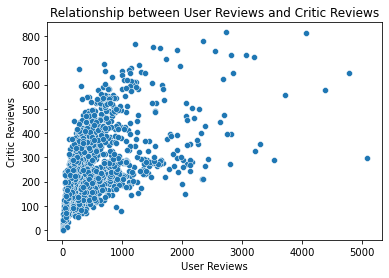

In [24]:
# Step 4: Visualize the relationship
sns.scatterplot(data=df, x='user_reviews', y='critic_reviews')
plt.title('Relationship between User Reviews and Critic Reviews')
plt.xlabel('User Reviews')
plt.ylabel('Critic Reviews')
plt.show()

Find the Pearson's correlation coefficient(r) between the 2 features.

In [25]:
# Filter out rows where either 'user_reviews' or 'critic_reviews' is NaN
filtered_df = df.dropna(subset=['user_reviews', 'critic_reviews'])

# Calculate Pearson's correlation coefficient on the filtered data
r, p_value = pearsonr(filtered_df['user_reviews'], filtered_df['critic_reviews'])
print(f"Pearson's correlation coefficient: {r}, p-value: {p_value}")


Pearson's correlation coefficient: 0.495843761606661, p-value: 1.0727233412973182e-76


Plot the average “duration” per “certificate” feature

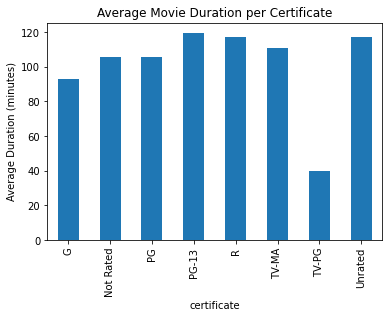

In [26]:
# Plotting the average movie duration for each certificate category
average_duration = df.groupby('certificate')['duration'].mean()
average_duration.plot(kind='bar', title='Average Movie Duration per Certificate')
plt.ylabel('Average Duration (minutes)')
plt.show()


histogram for the “genre” feature after splitting by genre field

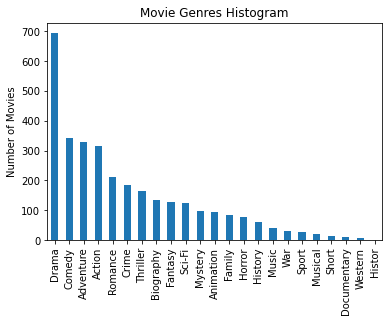

In [27]:
all_genres = df['genre'].str.split('|').explode()
all_genres.value_counts().plot(kind='bar', title='Movie Genres Histogram')
plt.ylabel('Number of Movies')
plt.show()


Remove all of the features which has the convention “Oscar_Best_XXX_won” except for the target variable “Oscar_Best_Picture_won”.

In [28]:
# List all columns that should be removed, except the target variable
columns_to_remove = [col for col in df.columns if col.startswith('Oscar_Best_') and col.endswith('_won') and col != 'Oscar_Best_Picture_won']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_remove)

Convert the target variable’s type to a numerical type by doing the transformation, “Yes” = 1, “No” = 0.

In [29]:
df['Oscar_Best_Picture_won'] = df['Oscar_Best_Picture_won'].map({'Yes': 1, 'No': 0})


Remove columns with high cardinality, i.e., for every column that has a unique value frequency of 70% or higher, remove them from the dataset.

In [30]:
# Preparing to identify and remove columns with predominantly unique values
columns_to_remove = []

# Evaluating each column for its proportion of unique entries
for col in df.columns:
    if (df[col].nunique() / df.shape[0]) > 0.7:  # Criteria for high uniqueness
        columns_to_remove.append(col)

# Creating a new DataFrame without the columns identified for removal
df_filtered = df.drop(columns=columns_to_remove)
print("Number of columns removed:", len(columns_to_remove))
print("New number of features:", df_filtered.shape[1])

Number of columns removed: 6
New number of features: 106


Preprocessing

In [31]:
# Select columns to be one-hot encoded
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Create the training dataset for movies released from 2000 to 2017
train_dataset = df_encoded[(df_encoded['year'] >= 2000) & (df_encoded['year'] <= 2017)]

# Create the test dataset for movies released in 2018
test_dataset = df_encoded[df_encoded['year'] == 2018]

Perform a time split and create a training dataset spanning the period 2000-2017 and a test dataset for the movies released in 2018 - use “year” feature for the data split and build a tree based model

In [32]:
# Importing necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Preparing data for model training and evaluation
features_train = train_dataset.drop(columns=['Oscar_Best_Picture_won', 'year'])
target_train = train_dataset['Oscar_Best_Picture_won']
features_test = test_dataset.drop(columns=['Oscar_Best_Picture_won', 'year'])
target_test = test_dataset['Oscar_Best_Picture_won']

# Configuring the XGBoost model
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fitting the model with training data
model_xgb.fit(features_train, target_train)

# Predicting the outcomes for the test set
predictions = model_xgb.predict(features_test)

# Calculating model performance metrics
model_accuracy = accuracy_score(target_test, predictions)
matrix_confusion = confusion_matrix(target_test, predictions)
report_classification = classification_report(target_test, predictions)

# Displaying the results
print(f"Model Accuracy: {model_accuracy:.4f}")
print("Confusion Matrix:")
print(matrix_confusion)
print("Detailed Classification Report:")
print(report_classification)


Model Accuracy: 1.0000
Confusion Matrix:
[[52]]
Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



predict the test dataset and find the maximum predicted value

In [33]:
import numpy as np

# Predicting probabilities for the positive class ('winning Best Picture')
predicted_probabilities = model_xgb.predict_proba(features_test)[:, 1]

# Finding the index of the highest predicted probability
max_probability_index = np.argmax(predicted_probabilities)
max_probability = predicted_probabilities[max_probability_index]

# Printing the index and probability of the movie with the highest chance to win
print(f"Index of movie with highest prediction to win Best Picture: {max_probability_index}")
print(f"Predicted probability of winning: {max_probability:.4f}")


Index of movie with highest prediction to win Best Picture: 32
Predicted probability of winning: 0.0637


find the movie in 2018 that is associated with the maximum predicted value.

In [34]:
movies_2018 = df[df['year'] == 2018]
predicted_movie_2018 = movies_2018.iloc[max_probability_index]['movie']
print(f"The movie in 2018 with the highest predicted probability to win Best Picture is: {predicted_movie_2018}")

The movie in 2018 with the highest predicted probability to win Best Picture is: Green Book
